# Atmospheric Correction (AC) for Remotely sensed Optical imagery : Using Radiative Transfer

For Remotely Sensed Optical (Multispectral/Hyperspectral) Images, The sensor acquired radiance (L) needs to be corrected for the 1. Atmoshperic gaseous transmittance (τ<sub>g</sub>), 2. Rayleigh-aerosol combined scattering in the atmoshperic column (Path radiance; L<sub>p</sub>) to calculate the surface reflectance (ρ). The theory of Radiave Transfer can be used in following way to algebrically express these quantities:

### ρ = π(L -L<sub>p</sub>) / τ<sub>g</sub>(E<sub>dir</sub> + E<sub>dif</sub>)

where
* ρ = surface reflectance
* L = at-sensor radiance
* L<sub>p</sub> = path radiance (Rayeligh + Aerosol)
* τ<sub>g</sub> = gaseous transmissivity (from surface to satellite)
* E<sub>dir</sub> = direct solar irradiance 
* E<sub>dif</sub> = diffuse solar irradiance
* π = 3.1415 (pi)

### 1. Loading dependencies

In [55]:
import xarray as xr
import rioxarray as rxr
import numpy as np
from Py6S import *
import datetime
import math
import os
import sys
import atmos
from datetime import datetime, timedelta
import act
import ee
import os
import sys
import matplotlib.pyplot as plt
import rasterio
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),'bin'))
from interpolated_LUTs import *
from interpolated_LUTs import Interpolated_LUTs

#### Before starting the process, we need to authenticate and initialize the Earth Engine module (make sure to create a Google cloud project earlier and also to register the project on Google Earth Engine)

In [56]:
ee.Authenticate()
ee.Initialize()

### Read the metadata as a Python dictionary

In [57]:
def read_metadata(file_path):
    """
    Reads a metadata file and returns a dictionary of variables.

    Parameters:
    file_path (str): The path to the metadata file.

    Returns:
    dict: A dictionary containing the variables from the metadata file.
    """
    variables_dict = {}
    
    # Open the Metadata
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()
        print("Metadata is being read...")

    for line in lines:
        # Split the line at the '=' sign
        parts = line.split('=')
        variable = parts[0].strip()  # Strip any whitespace characters
        value = parts[1].strip()
        variables_dict[variable] = value

    return variables_dict


### Important Metadata variables for AC

In [58]:
file_path = '/home/jovyan/Rasters/CARTOSAT/Delhi/BAND_META.txt'
variables_dict = read_metadata(file_path)

print(f"Sensor name: {variables_dict.get('atID')}-{variables_dict.get('Sensor')}")
print(f"Spectral band count: {variables_dict.get('NoOfBands')}")
print(f"Acquisition time: {variables_dict.get('SceneCentreTime')}")
print(f"Sun Zenith: {variables_dict.get('SunElevationAtCenter')}")
print(f"Scene center geometry: LAT = {variables_dict.get('SceneCenterLat')} , LON = {variables_dict.get('SceneCenterLon')}")

scene_date = datetime.strptime(variables_dict.get('SceneCentreTime'), "%d-%b-%Y %H:%M:%S:%f")
solar_z = variables_dict.get('SunElevationAtCenter')
geom = ee.Geometry.Polygon(
    [[[float(variables_dict.get('ImageULLon')), float(variables_dict.get('ImageULLat'))],
      [float(variables_dict.get('ImageURLon')), float(variables_dict.get('ImageURLat'))],
      [float(variables_dict.get('ImageLRLon')), float(variables_dict.get('ImageLRLat'))],
      [float(variables_dict.get('ImageLLLon')), float(variables_dict.get('ImageLLLat'))]]]
)

Metadata is being read...
Sensor name: None-MX
Spectral band count: 4
Acquisition time: 07-Jun-2023 04:28:40:3551
Sun Zenith: 58.36724
Scene center geometry: LAT = 28.62515193 , LON = 77.21971436


### 2. Anciliary Functions for retrieval of Water Vapour, Ozone, Aerosol Optical Thickness (AOT) and target altitude

#### Methods to approximate the acquisition time and date

In [59]:
def round_date(date, xhour):
    """
    Rounds a date to the closest 'x' hours
    """
    rounded_date = date - timedelta(hours=date.hour % xhour, minutes=date.minute, seconds=date.second, microseconds=date.microsecond)
    rounded_date += timedelta(hours=xhour//2)
    return rounded_date

def round_month(date):
    """
    Round date to the closest month
    """
#     date = ee.Date(date)
    # Start of THIS month
    m1 = ee.Date.fromYMD(date.get('year'), date.get('month'), ee.Number(1))
    
    # Start of NEXT month
    m2 = m1.advance(1, 'month')
      
    # Difference from date
    d1 = ee.Number(date.difference(m1, 'day')).abs()
    d2 = ee.Number(date.difference(m2, 'day')).abs()
    
    # Return closest start of month
    closest_month = ee.Algorithms.If(d2.gt(d1), m1, m2)
    
    return ee.Date(closest_month)


#### Method to obtain water vapour data for the scene

In [60]:
import ee

def water(geom, date):
    """
    Water vapour column above target at time of image aquisition.
    
    (Kalnay et al., 1996, The NCEP/NCAR 40-Year Reanalysis Project. Bull. 
    Amer. Meteor. Soc., 77, 437-471)
    """
    
    # Point geometry required
    centroid = geom.centroid()
    
    # Convert Python datetime to Earth Engine ee.Date
    H2O_date = ee.Date(round_date(date, 2))
    
    # Filtered water collection
    water_ic = ee.ImageCollection('NCEP_RE/surface_wv').filterDate(H2O_date, H2O_date.advance(1, 'month'))
    
    # Water image
    water_img = ee.Image(water_ic.first())
    
    # Water vapour at target
    water = water_img.reduceRegion(reducer=ee.Reducer.mean(), geometry=centroid).get('pr_wtr')
                                        
    # Convert to Py6S units (Google = kg/m^2, Py6S = g/cm^2)
    water_Py6S_units = ee.Number(water).divide(10)   
    
    # Get the numerical result
    water_value = water_Py6S_units.getInfo()
    
    return water_value


#### Method to obtain Ozone data for the scene

In [61]:
import ee

def ozone(geom, date):
    """
    Returns ozone measurement from the merged TOMS/OMI dataset
    or uses the fill value (mean value for that lat/lon and day-of-year).
    """
    
    # Point geometry required
    centroid = geom.centroid()
       
    def ozone_measurement(centroid, o3_date):
        # Filtered ozone collection
        
        ozone_ic = ee.ImageCollection('TOMS/MERGED').filterDate(o3_date, o3_date.advance(1, 'month'))
        
        # Ozone image
        ozone_img = ee.Image(ozone_ic.first())
        
        # Ozone value if TOMS/OMI image exists, else use fill value
        ozone = ee.Algorithms.If(
            ozone_img,
            ozone_img.reduceRegion(reducer=ee.Reducer.mean(), geometry=centroid).get('ozone'),
            ozone_fill(centroid, o3_date)
        )
        
        return ozone
      
    def ozone_fill(centroid, o3_date):
        """
        Gets our ozone fill value (i.e. mean value for that doy and latlon)
        """
        # Ozone fills (i.e., one band per doy)
        
        ozone_fills = ee.ImageCollection('users/samsammurphy/public/ozone_fill').toList(366)
        
        # Day of year index
        jan01 = ee.Date.fromYMD(o3_date.get('year'), 1, 1)
        doy_index = o3_date.difference(jan01, 'day').toInt()  # (NB. index is one less than doy, so no need to +1)
        
        # Day of year image
        fill_image = ee.Image(ozone_fills.get(doy_index))
        
        # Return scalar fill value
        return fill_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=centroid).get('ozone')
     
    # O3 datetime in 24-hour intervals
    o3_date = ee.Date(round_date(date, 24))
    
    # TOMS temporal gap
    toms_gap = ee.DateRange('2022-01-01', '2023-01-01')  
    
    # Avoid TOMS gap entirely
    ozone = ee.Algorithms.If(toms_gap.contains(o3_date),
                             ozone_fill(centroid, o3_date),
                             ozone_measurement(centroid, o3_date))
    
    # Fix other data gaps (e.g., spatial, missing images, etc.)
    ozone = ee.Algorithms.If(ozone, ozone, ozone_fill(centroid, o3_date))
    
    # Convert to Py6S units 
    ozone_py6s_units = ee.Number(ozone).divide(1000)  # Dobson units are milli-atm-cm
    
    ozone_value = ozone_py6s_units.getInfo()
    
    return ozone_value


#### Method to obtain Aerosol Optical Thickness (AOT) at 550 nm data for the scene

In [62]:
def aerosol(geom, date):
    """
    Aerosol Optical Thickness.

    try:
        MODIS Aerosol Product (monthly)
    except:
        fill value
    """
    date_t = date.strftime('%Y-%m-%d')
    date = ee.Date(date)
    
    def aerosol_fill(date):
        """
        MODIS AOT fill value for this month (i.e., no data gaps)
        """
        return (
            ee.Image('users/samsammurphy/public/AOT_stack')
            .select([ee.String('AOT_').cat(date.format('M'))])
            .rename(['AOT_550'])
        )

    def aerosol_this_month(date):
        """
        MODIS AOT original data product for this month (i.e., some data gaps)
        """
        # Image for this month
        img = ee.ImageCollection('MODIS/006/MOD08_M3')\
            .filterDate(round_month(date))\
            .first()

        # Fill missing month (?)
        img = ee.Algorithms.If(
            img,
            # All good
            img.select(['Aerosol_Optical_Depth_Land_Mean_Mean_550'])
                .divide(1000)
                .rename(['AOT_550']),
            # Missing month
            aerosol_fill(date)
        )

        return img

    def get_AOT(AOT_band, geom):
        """
        AOT scalar value for the target
        """
        return (
            ee.Image(AOT_band)
            .reduceRegion(reducer=ee.Reducer.mean(), geometry=geom.centroid())
            .get('AOT_550')
        )

    after_modis_start = date.difference(ee.Date(date_t), 'month').gt(0)

    AOT_band = ee.Algorithms.If(
        after_modis_start,
        aerosol_this_month(date),
        aerosol_fill(date)
    )

    AOT = get_AOT(AOT_band, geom)

    AOT = ee.Algorithms.If(
        AOT,
        AOT,
        get_AOT(aerosol_fill(date), geom)
    )
    # i.e. check reduce region worked (else force fill value)
    AOT = AOT.getInfo()
    return AOT

#### Obtain the target elevation for the scene

In [63]:
SRTM = ee.Image('CGIAR/SRTM90_V4')# Shuttle Radar Topography mission covers *most* of the Earth
alt = SRTM.reduceRegion(reducer = ee.Reducer.mean(),geometry = geom.centroid()).get('elevation').getInfo()
km = alt/1000

### 3. Read and Plot the Multispectral raster(s)

#### Method to convert DN values to TOA Radiance band-by-band

In [64]:
def DN2Radiance(band_number, band_path, output_path):
    # Open dataset
    band_ds = xr.open_dataset(f'{band_path}/BAND{band_number}.tif', engine='rasterio')
    
    # Define L_min, L_max excluding NaN values
    band_data = band_ds.band_data.values[0]
    valid_values = band_data[~np.isnan(band_data)]
    B_Lmin = np.min(valid_values)
    B_Lmax = {1: float(variables_dict.get('B1Lmax')), 
              2: float(variables_dict.get('B2Lmax')), 
              3: float(variables_dict.get('B3Lmax')), 
              4: float(variables_dict.get('B4Lmax'))}[band_number]
    
    # Radiance conversion following Mishra et al.
    B_L = (B_Lmax / 2047) * band_data 
    
    # Create xarray DataArray
    B_xr = xr.DataArray(B_L, dims=('y', 'x'), coords={'y': band_ds.coords['y'], 'x': band_ds.coords['x']}, name=f'BAND{band_number}')
    B_xr.rio.write_crs(band_ds.rio.crs, inplace=True)
    
    # Save to raster
    B_xr.rio.to_raster(f"{output_path}/B{band_number}_C3_radiance.tif")


#### Method to stack TOA Radiance/BOA Reflectance for all bands

In [65]:
def merge_bands(mode, band_path, band_numbers, output_path):

    if mode == "rad":
         band_paths = [f"{band_path}/B{band_number}_C3_radiance.tif" for band_number in band_numbers]
    elif mode == "ref":
        band_paths = [f"{band_path}/B{band_number}_C3_reflectance.tif" for band_number in band_numbers]
    else:
        raise ValueError("Invalid mode or output_path not provided for 'ref' mode.")
    
    #band_paths = [f"{base_path}/B{band_number}R_Car1_mishra_etal.tif" for band_number in band_numbers]

    # Open bands
    bands = [rxr.open_rasterio(band_path) for band_path in band_paths]

    # Extract band data
    band_data = [band.data[0] for band in bands]

    # Create xarray DataArrays
    band_xr = [xr.DataArray(data, dims=('y', 'x'), coords={'y': band.coords['y'], 'x': band.coords['x']},
                            name=f'BAND{band_number}') for band_number, (band, data) in zip(band_numbers, zip(bands, band_data))]

    # Merge DataArrays
    merged_xr = xr.merge(band_xr)
    merged_xr = merged_xr.fillna(0)

    # Set CRS and save to raster
    merged_xr.rio.write_crs(bands[0].rio.crs, inplace=True)
    
    if mode == "rad":
         merged_xr.rio.to_raster(f"{output_path}/_C3_radiance_stack.tif")
    else:
        merged_xr.rio.to_raster(f"{output_path}/_C3_reflectance_stack.tif")


#### Method to visualize TOA Radiance/ BOA reflectance for a given band 

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties

def plot_raster_tile(mode, band_number, band_path, x, y):
    # Open dataset
    # Determine the image path based on mode
    if mode == "rad":
        img_path = f"{band_path}/B{band_number}_C3_radiance.tif"
    elif mode == "ref":
        img_path = f"{band_path}/B{band_number}_C3_reflectance.tif"
    else:
        raise ValueError("Invalid mode or path")
        
    img = xr.open_dataset(img_path, engine='rasterio')
    img_data = img.band_data.values[:].astype(np.float32)[:, x:x+512, y:y+512]

    print(f"Maximum Value : {img_data.max()}")
    print(f"Minimum Value : {img_data.min()}")

    # Normalize each band between 0 and 1
    img_data_normalized = img_data

    plt.figure(figsize=(5, 5))
    img_plot = plt.imshow(img_data_normalized.transpose(1, 2, 0))  # Transpose to (height, width, bands).
    plt.axis('on')

    # Add colorbar
    cbar = plt.colorbar(img_plot, orientation='vertical')
    if mode == "rad":
        cbar.set_label('TOA Radiance ($\mu W/ m^2/sr/\mu m$)')
    elif mode == "ref":
        cbar.set_label('BOA Reflectance (Unitless)')
    else:
        raise ValueError("Invalid mode or path")
    

    # Determine the scale of the image
    pixel_size = 1.5  # meters
    scalebar_length = 150  # meters (adjust as needed)
    scalebar_pixels = scalebar_length // pixel_size

    # Create the scale bar
    fontprops = FontProperties(size=12)
    scalebar = AnchoredSizeBar(plt.gca().transData,
                               scalebar_pixels, f'{scalebar_length} m', 'lower right',
                               pad=0.1, color='white', frameon=False,
                               size_vertical=1, fontproperties=fontprops)

    plt.gca().add_artist(scalebar)
    plt.show()



#### Read the DN bands and convert to TOA Radiance on disc

In [68]:
# Compute and Save Radiance Bands
band_path = '/home/jovyan/Rasters/CARTOSAT/Delhi'
output_path = '/home/jovyan/Rasters/CARTOSAT/Delhi'

for band_number in range(1, 5):
    DN2Radiance(band_number, band_path, output_path)


#### Plot the TOA Radiance for a given band (as tile)

Maximum Value : 9.215339660644531
Minimum Value : 3.549877882003784


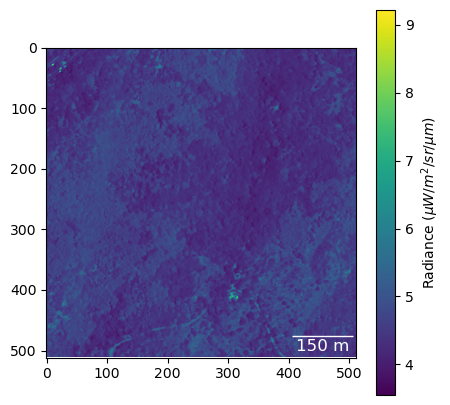

In [74]:
plot_raster_tile("rad",3, band_path, 9000,2500)

### 4. Perform the Atmoshperic Correction

#### Obtain the Path Radiance and Gaseous transmittance for the scene from 6S obtained LOOK-UP TABLES (LUTs) 

In [19]:
import os
import glob
import pickle

ilut_path = '/home/jovyan/6S_emulator/files/iLUTs/user-defined-sensor/Continental/view_zenith_0/'
iLUTs = {} 

# Load iLUTs
filepaths = glob.glob(ilut_path + '*.ilut')
if filepaths:
    try:
        for fpath in filepaths:  
            bandName = os.path.basename(fpath).split('.')[1] 
            with open(fpath, "rb") as ilut_file:  
                iLUTs[bandName] = pickle.load(ilut_file)  
    except Exception as e:  
        print('Problem loading interpolated look up table (.ilut) files:', e)
else:
    print('Looked for iLUTs but did not find any in:\n{}'.format(ilut_path))


In [20]:
# See the LUT entry for each dictionary key for each band
for band_name, ilut_data in iLUTs.items():
    print(f"ILUT data for band {band_name}:")
    print(ilut_data)


ILUT data for band 650:
ILUT data for band 555:
ILUT data for band 485:
ILUT data for band 815:


#### Obtain LUT interpolated Path Radiance and Atmospheric Gaseous transmittance (a,b) corrected for the Earth's eliptical orbit

In [75]:
import math

sun_zen = solar_z # Sun Zenith angle for the scene
h2o = water(geom, scene_date) # Water Vapur for the scene
o3 = ozone(geom, scene_date) #ozone for the scene
aot = aerosol(geom, scene_date) #AOT for the scene

print(f"Scene Sun Zenith: ", sun_zen, "degrees")
print(f"Scene Water Vapour: ", h2o, "gm/cm^2")
print(f"Scene Ozone: ", o3, "cm-atm")
print(f"Scene AOT550: ", aot)
print(f"Scene elevation: ", km, "km")

bands = ['485', '555', '650', '815']
coefficients_a = {}
coefficients_b = {}

elliptical_orbit_correction = 0.03275104 * math.cos(4 / 59.66638337) + 0.96804905

for band in bands:
    ilut = iLUTs[band]
    a, b = ilut(sun_zen, h2o, o3, aot, km)
    
    # Apply elliptical orbit correction to 'a' and 'b' values
    a_corrected = a * elliptical_orbit_correction
    b_corrected = b * elliptical_orbit_correction
    
    coefficients_a[band] = a_corrected
    coefficients_b[band] = b_corrected

# Dictionary mapping old keys to new keys
key_mapping = {'485': 1, '555': 2, '650': 3, '815': 4}

# Renamed dictionary using a dictionary comprehension
coefficients_a_num = {key_mapping.get(key, key): value for key, value in coefficients_a.items()}
coefficients_b_num = {key_mapping.get(key, key): value for key, value in coefficients_b.items()}

print("Elliptical orbit corrected coefficients for a:")
print(coefficients_a_num)
print("\nElliptical orbit corrected coefficients for b:")
print(coefficients_b_num)


Scene Sun Zenith:  58.36724 degrees
Scene Water Vapour:  2.720000076293945 gm/cm^2
Scene Ozone:  0.302 cm-atm
Scene AOT550:  1.2740000486373901
Scene elevation:  0.219 km
Elliptical orbit corrected coefficients for a:
{1: 56.77775981981118, 2: 43.281518323308724, 3: 29.555802339769308, 4: 12.051626831046727}

Elliptical orbit corrected coefficients for b:
{1: 92.38223200639007, 2: 103.56415513582154, 3: 102.91436544451123, 4: 52.89647126231675}


#### Method to perform atmospheric correction using interpolated a and b 

In [78]:
def get_coefficients(band_number, coefficients_dict):
    if band_number in coefficients_dict:
        return coefficients_dict[band_number]
    else:
        return None 

def Rad2Ref(band_number, band_path, output_path, LUT_a, LUT_b):
    # Open Raster of radiance
    band_ds = xr.open_dataset(f"{band_path}/B{band_number}_C3_radiance.tif", engine='rasterio')
    
    #Fetch the a and b coeffcieints for the band number
    a_coeff = get_coefficients(band_number, LUT_a)
    b_coeff = get_coefficients(band_number, LUT_b)
    print(f"The a coefficient for band {band_number}: {a_coeff}")
    print(f"The b coefficient for band {band_number}: {b_coeff}")
    
    # Define L_min, L_max excluding NaN values
    band_data = band_ds.band_data.values[0]*10 #Check the consistency between radiance units of LUT instance vs TOA value
    valid_values = band_data[~np.isnan(band_data)]
    B_Lmin = np.min(valid_values)
    
    # Radiance to Reflectance conversion
    B_L = (band_data-a_coeff)/b_coeff
    
    # Create xarray DataArray
    B_xr = xr.DataArray(B_L, dims=('y', 'x'), coords={'y': band_ds.coords['y'], 'x': band_ds.coords['x']}, name=f'BAND{band_number}')
    B_xr.rio.write_crs(band_ds.rio.crs, inplace=True)
    
    # Save to raster
    B_xr.rio.to_raster(f"{output_path}/B{band_number}_C3_reflectance.tif")


#### Atmospherically correct multispectral TOA Radiance scene band-by-band

In [79]:
for band_number in range(1, 5):
    Rad2Ref(band_number=band_number, band_path= band_path, output_path= output_path, LUT_a= coefficients_a_num, LUT_b= coefficients_b_num)


The a coefficient for band 1: 56.77775981981118
The b coefficient for band 1: 92.38223200639007
The a coefficient for band 2: 43.281518323308724
The b coefficient for band 2: 103.56415513582154
The a coefficient for band 3: 29.555802339769308
The b coefficient for band 3: 102.91436544451123
The a coefficient for band 4: 12.051626831046727
The b coefficient for band 4: 52.89647126231675


Maximum Value : 0.608249306678772
Minimum Value : 0.057746823877096176


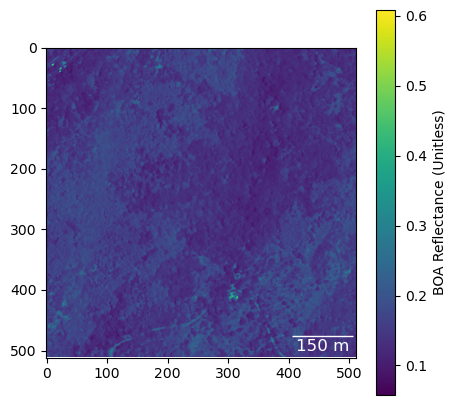

In [83]:
plot_raster_tile("ref",3, band_path, 9000,2500)

#### Stack the BOA reflectance for all bands on disc

In [74]:
# Merge Radiance Bands 
band_numbers = [1, 2, 3, 4]
merge_radiance_bands("ref",band_path, band_numbers, output_path)

# Atmospheric Correction (AC) for Remotely sensed Optical imagery : Using Dark Object Subtraction

Wavelength(0.43, 0.50)
def spectralResponseFunction(bandname):
    """
    Extract spectral response function for given band name
    """
    bandSelect = {
        'B1':Wavelength(0.45, 0.52),
        'B2':Wavelength(0.52, 0.59),
        'B3':Wavelength(0.62, 0.68),
        'B4':Wavelength(0.77, 0.86)
        }
    return bandSelect[bandname]

In [82]:
spectralResponseFunction('B1')

('0 constant filter function\n0.450000 0.520000\n', 0.45, 0.52)